# Hierarchical clustering program using different distance measures

Use pm4py for importing different event logs found in logs folder

In [2]:
# Reloads the local files if they change
%load_ext autoreload
%autoreload 2

# import local files
import Jaccard
import Simrank
import Log_processing
import Clustering

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# TESTING
def weighted_simrank(G, node1, node2, C=0.8, max_iterations=100, tolerance=1e-6):
    if node1 == node2:
        return 1.0

    prev_sim = 0
    sim = 1
    iterations = 0

    while abs(sim - prev_sim) > tolerance and iterations < max_iterations:
        prev_sim = sim
        neighbors1 = set(G.predecessors(node1))
        neighbors2 = set(G.predecessors(node2))
        sim = C / (len(neighbors1) * len(neighbors2)) * sum(G[node1][x]['weight'] * G[node2][y]['weight'] * weighted_simrank(G, x, y, C, max_iterations, tolerance) for x in neighbors1 for y in neighbors2)
        iterations += 1

    return sim

def full_weighted_simrank(G):
    similarities = {}
    for node1 in G.nodes():
        node_similarity = {}
        for node2 in G.nodes():
            node_similarity[node2] = weighted_simrank(G, node1, node2)
        similarities[node1] = {}

In [8]:
def show_dendrograms_for_event_log(log, figure_title, output_file_name):
    '''
    Prints the dendrograms from a given log using all distance measures, saves the generated figure in out folder
    '''

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(figure_title)

    ax[0, 0].set_title("Simple Jaccard")
    ax[0, 1].set_title("Weighted Jaccard")
    ax[1, 0].set_title("Simple Simrank")
    ax[1, 1].set_title("Weighted Simrank")

    simple_jaccard = Jaccard.Simple_Jaccard(log)
    weighted_jaccard = Jaccard.Weighted_Jaccard(log)
    simple_simrank = Simrank.Simple_Simrank(log)
    weighted_simrank = Simrank.Weighted_Simrank(log)

    simple_jaccard.perform_clustering(ax=ax[0, 0])
    weighted_jaccard.perform_clustering(ax=ax[0, 1])
    simple_simrank.perform_clustering(ax=ax[1, 0])
    weighted_simrank.perform_clustering(ax=ax[1, 1])

    fig.tight_layout()
    plt.show()
    fig.savefig("../out/" + output_file_name)

Analyze the Sepsis event log

In [ ]:
sepsis = Log_processing.get_log("../logs/sepsis_event_log.xes")
show_dendrograms_for_event_log(sepsis, "Sepsis Clustering", "sepsis.jpg")

Analyze the Coselog event log

parsing log, completed traces ::   0%|          | 0/1434 [00:00<?, ?it/s]

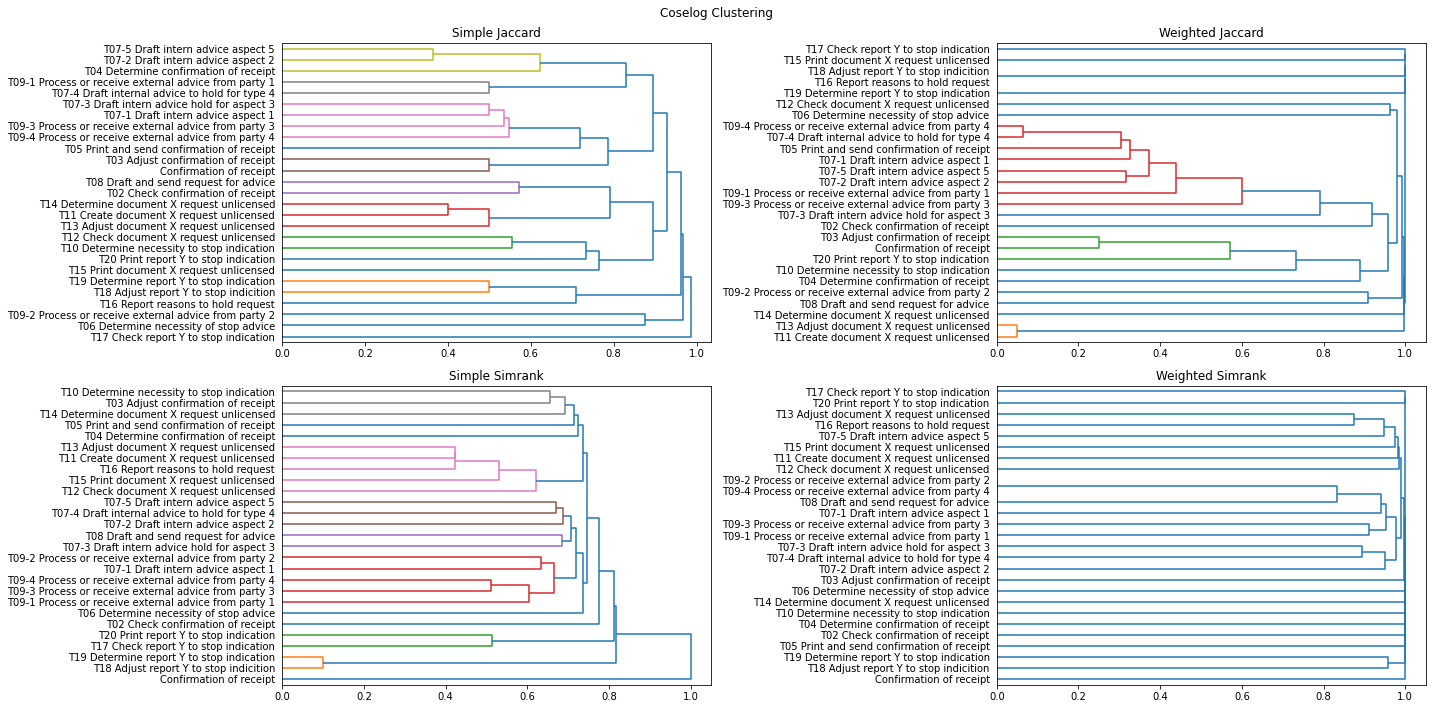

In [9]:
coselog = Log_processing.get_log("../logs/coselog.xes")
show_dendrograms_for_event_log(coselog, "Coselog Clustering", "coselog.jpg")

Analyze the BPI Challenge event log

In [ ]:
bpic = Log_processing.get_log("../logs/BPI_Challenge_2013_incidents.xes")
show_dendrograms_for_event_log(bpic, "BPIC Clustering", "bpic.jpg")

Analyze the Road traffic fine event log

In [ ]:
road_traffic = Log_processing.get_log("../logs/Road_Traffic_Fine_Management_Process.xes")
show_dendrograms_for_event_log(road_traffic, "Road traffic fines Clustering", "Road_traffic_fines.jpg")

In [ ]:
# Testing
log = Log_processing.get_log("../logs/coselog.xes")
weighted_jaccard = Jaccard.Weighted_Jaccard(log)
weighted_jaccard.perform_clustering()